In [18]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Compose
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, blur_dir, motion_blur_dir, clear_dir, transform=None, target_size=(256, 256), num_images=100):
        self.blur_dir = blur_dir
        self.motion_blur_dir = motion_blur_dir
        self.clear_dir = clear_dir
        self.transform = transform
        self.target_size = target_size
        self.num_images = num_images

        # Get sorted list of image file names in each directory
        self.blur_images = sorted(os.listdir(blur_dir))[:num_images]
        self.motion_blur_images = sorted(os.listdir(motion_blur_dir))[:num_images]
        self.clear_images = sorted(os.listdir(clear_dir))[:num_images]

        # Ensure alignment by matching images based on their position in the sorted lists
        self.image_names = self._align_images()

    def _align_images(self):
        num_images = min(len(self.blur_images), len(self.motion_blur_images), len(self.clear_images), self.num_images)
        aligned_names = []
        for i in range(num_images):
            blur_name = self.blur_images[i]
            motion_blur_name = self.motion_blur_images[i]
            clear_name = self.clear_images[i]
            aligned_names.append((blur_name, motion_blur_name, clear_name))
        return aligned_names

    def __len__(self):
        return min(len(self.image_names), self.num_images)

    def __getitem__(self, idx):
        blur_name, motion_blur_name, clear_name = self.image_names[idx]

        blur_img_path = os.path.join(self.blur_dir, blur_name)
        motion_blur_img_path = os.path.join(self.motion_blur_dir, motion_blur_name)
        clear_img_path = os.path.join(self.clear_dir, clear_name)

        # Loading images using PIL
        blur_image = Image.open(blur_img_path).convert('RGB')
        motion_blur_image = Image.open(motion_blur_img_path).convert('RGB')
        clear_image = Image.open(clear_img_path).convert('RGB')

        # Resizing images to target size
        resize_transform = Resize(self.target_size)
        blur_image = resize_transform(blur_image)
        motion_blur_image = resize_transform(motion_blur_image)
        clear_image = resize_transform(clear_image)

        # applying transformations
        if self.transform:
            blur_image = self.transform(blur_image)
            motion_blur_image = self.transform(motion_blur_image)
            clear_image = self.transform(clear_image)

        return blur_image, motion_blur_image, clear_image

# Defining transforms
transform = Compose([
    ToTensor()
])

# Define directories containing the images
blur_dir = 'C:/Users/Aravind/Desktop/BCS Proj/blur_dataset/blur_dataset/defocused_blurred'
motion_blur_dir = 'C:/Users/Aravind/Desktop/BCS Proj/blur_dataset/blur_dataset/motion_blurred'
clear_dir = 'C:/Users/Aravind/Desktop/BCS Proj/blur_dataset/blur_dataset/sharp'

# Create dataset with only the first 100 images
#using first 100 images also took a lot of time to load so i took 10 and checked
dataset = ImageDataset(blur_dir, motion_blur_dir, clear_dir, transform=transform, num_images=10)

# print the number of images found
print(f"Number of images found: {len(dataset)}")

# Creating DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Number of images found: 10


In [20]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with avgpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avgpool_conv = nn.Sequential(
            nn.AvgPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.avgpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Initializing model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=3).to(device)  # Moving model to GPU if available
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [21]:
#training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for blur_images, motion_blur_images, clear_images in dataloader:
        try:
            # Moving inputs and targets to GPU if available
            blur_images, motion_blur_images, clear_images = blur_images.to(device), motion_blur_images.to(device), clear_images.to(device)
            inputs = motion_blur_images 
            targets = clear_images

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        except: Exception


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


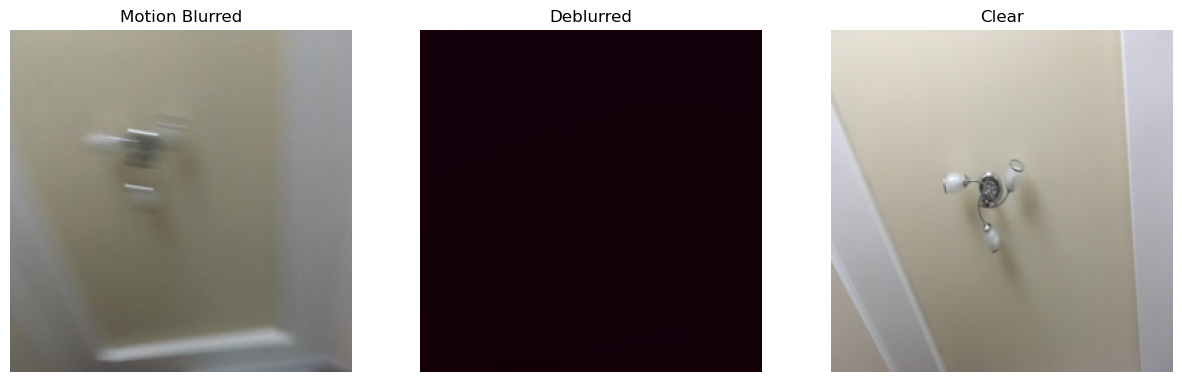

In [22]:
import torch.nn.functional as F
# displaying an example of the result
model.eval()
with torch.no_grad():
    for blur_images, motion_blur_images, clear_images in dataloader:
        blur_images, motion_blur_images, clear_images = blur_images.to(device), motion_blur_images.to(device), clear_images.to(device)
        inputs = motion_blur_images
        outputs = model(inputs)
        break  # Display results of the first batch

# converting tensor to numpy array for visualization
def to_numpy(tensor):
    return tensor.cpu().numpy().transpose((1, 2, 0))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(to_numpy(inputs[0]))
axs[0].set_title('Motion Blurred')
axs[1].imshow(to_numpy(outputs[0]))
axs[1].set_title('Deblurred')
axs[2].imshow(to_numpy(clear_images[0]))
axs[2].set_title('Clear')
for ax in axs:
    ax.axis('off')
plt.show()
